# Business Opportunity

If the management team have access to a sales prediction service, they can efficiently and accurately forecast revenue for a specific country for the following month, leading to savings in work time and improvements of budget planning.

- Can we more accurately predict sales?
- Are there seasonal patterns in sales?
- Are there trends in the sales?

Scope
- Consider only the ten countries with most revenue

# Ideal Data

- Historic sales data for several years: Important to see the seasonal as well as the trend patterns.
- Customer and location demographics data: Correlate sales with different customer segments, to make better predictions if we have info about the customer segments per country.

# Load Python Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import sys
plt.style.use('seaborn')
%matplotlib inline

In [64]:
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handlers = [
    logging.FileHandler(filename='../output/logs/ingestion.log'),
    logging.StreamHandler(sys.stderr)
]

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
for handler in handlers:
    handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = handlers

# EDA

In [3]:
DATA_DIR = os.path.join('..', 'data/source/cs-train')

def ingest_json_data(data_dir: str) -> pd.DataFrame:
    dfs = list()
    i = 0
    for file in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file)
        if not file_path.endswith('.json'):
            continue
        try:
            df = pd.read_json(file_path)
            df.columns = [c.lower().replace('_', '') for c in df.columns]
            df = df.rename(columns={'totalprice': 'price'})
            df = df.sort_index(axis=1)
            assert all(c in df.columns for c in ['country', 'customerid', 'day', 
                 'invoice', 'month', 'price', 'streamid', 'timesviewed', 'year'])
            dfs.append(df)
        except Exception as e:
            logging.error('Failed reading {}'.format(file_path))
            return None
        else:
            logging.info('Successfully read {}, {} rows'.format(file_path, df.shape[0]))
            i += 1
        
    full_df = pd.concat(dfs).reset_index(drop=True)
    logging.info('Successfully ingested {} files, {} total rows'.format(i, full_df.shape[0]))
    return full_df

df = ingest_json_data(DATA_DIR)

root - INFO - Successfully read ../data/source/cs-train/invoices-2018-01.json, 35682 rows
root - INFO - Successfully read ../data/source/cs-train/invoices-2017-12.json, 35726 rows
root - INFO - Successfully read ../data/source/cs-train/invoices-2019-01.json, 39121 rows
root - INFO - Successfully read ../data/source/cs-train/invoices-2018-11.json, 86138 rows
root - INFO - Successfully read ../data/source/cs-train/invoices-2018-07.json, 34097 rows
root - INFO - Successfully read ../data/source/cs-train/invoices-2019-06.json, 34601 rows
root - INFO - Successfully read ../data/source/cs-train/invoices-2019-07.json, 42018 rows
root - INFO - Successfully read ../data/source/cs-train/invoices-2018-06.json, 38987 rows
root - INFO - Successfully read ../data/source/cs-train/invoices-2018-10.json, 61752 rows
root - INFO - Successfully read ../data/source/cs-train/invoices-2018-09.json, 42379 rows
root - INFO - Successfully read ../data/source/cs-train/invoices-2019-04.json, 29825 rows
root - INF

In [4]:
df.head()

,country,customerid,day,invoice,month,price,streamid,timesviewed,year
0,United Kingdom,15581.0,1,493463,1,2.95,20895,1,2018
1,United Kingdom,15581.0,1,493463,1,1.25,20866,1,2018
2,United Kingdom,15581.0,1,493463,1,0.85,85198,12,2018
3,United Kingdom,15581.0,1,493463,1,2.95,20897,1,2018
4,United Kingdom,15581.0,1,493463,1,2.95,20898,1,2018


In [5]:
df.isnull().sum() / df.shape[0]

country        0.000000
customerid     0.232834
day            0.000000
invoice        0.000000
month          0.000000
price          0.000000
streamid       0.000000
timesviewed    0.000000
year           0.000000
dtype: float64

**Only customerid is containing missing values, ~23%**

In [6]:
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + df['day'].astype(str))

In [7]:
df['date'].max() - df['date'].min()

Timedelta('610 days 00:00:00')

**We have 610 days of data**

In [8]:
def bar_sum_aggregation(df, index, value, proportion=False, hue=None):
    agg_df = pd.pivot_table(df, index=index, values=value, aggfunc=sum).reset_index()
    agg_df = agg_df.sort_values(by=value, ascending=False)
    index_x = index[0] if isinstance(index, list) else index
    plt.figure(figsize=(20,5))
    chart = sns.barplot(x=index_x, y=value, data=agg_df, hue=hue)
    plt.ylabel(value)
    plt.xlabel(index_x)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

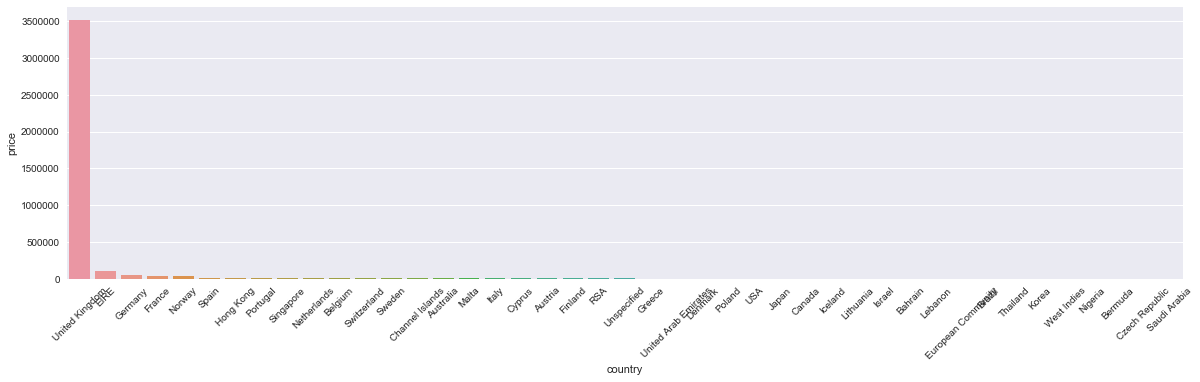

In [9]:
bar_sum_aggregation(df, 'country', 'price')

**Top 10 countries**
- United Kingdom
- EIRE
- Germany
- France
- Norway
- Spain
- Hong Kong
- Portugal
- Singapore
- Netherlands

In [10]:
df_scope = df.loc[df['country'].isin([
    'United Kingdom',
    'EIRE',
    'Germany',
    'France',
    'Norway',
    'Spain',
    'Hong Kong',
    'Portugal',
    'Singapore',
    'Netherlands'
])].reset_index(drop=True)
df_scope.shape

(797867, 10)

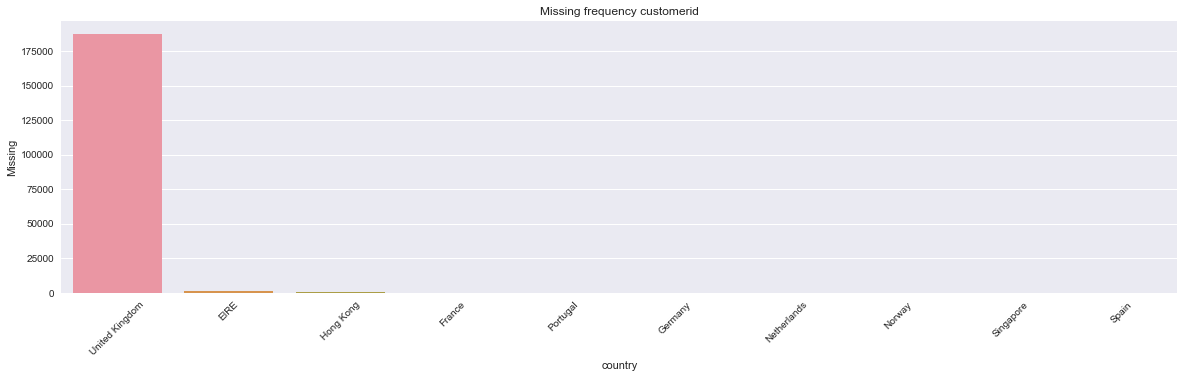

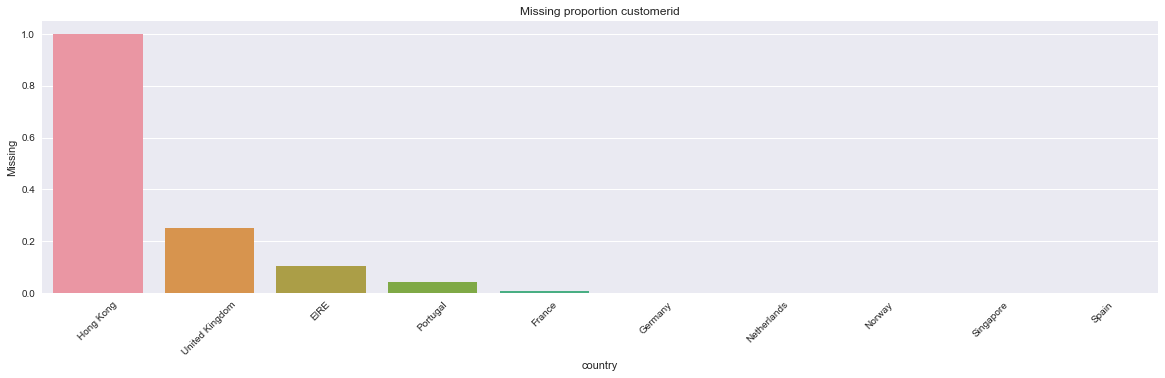

In [11]:
def missing_per_group(df, index, value, proportion=False):
    func = lambda x: x.isnull().sum()/x.shape[0] if proportion else x.isnull().sum()
    rev_df = pd.pivot_table(df, index=index, values=value, aggfunc=func).reset_index()
    rev_df = rev_df.sort_values(by=value, ascending=False)
    plt.figure(figsize=(20,5))
    plt.title('Missing {} {}'.format("proportion" if proportion else "frequency", value))
    chart = sns.barplot(x=index, y=value, data=rev_df)
    plt.ylabel('Missing')
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    
missing_per_group(df_scope, 'country', 'customerid')
missing_per_group(df_scope, 'country', 'customerid', True)

**UK has most missing customerids, however it it also the most selling country. Hong Kong has the most relative missing customerids.**

In [12]:
def sum_within_group(df: pd.DataFrame, target_column: str, group_columns: list = None) -> pd.Series:
    if group_columns is None:
        return pd.Series(np.full(df.shape[0], df[target_column].sum()), index=df.index)
    assert target_column not in group_columns, 'Target column cannot be passed as group column!'

    group_df = df.groupby(group_columns)[target_column].sum().reset_index()
    group_df = group_df.rename(columns={target_column: '__sum_within_group_result_column__'})

    df['__sum_within_group_copy_index__'] = df.index
    df = df.merge(group_df, on=group_columns, how='left')
    df.index = df['__sum_within_group_copy_index__']
    df.sort_index(inplace=True)
    return df['__sum_within_group_result_column__']


def proportion_within_group(df: pd.DataFrame, target_column: str, group_columns: list = None) -> pd.Series:
    if group_columns is None:
        sum_target = df[target_column].sum()
    else:
        sum_target = sum_within_group(df, target_column, group_columns)
    return df[target_column] / sum_target

def bar_country_aggregation(df, index, value, percentage=False, hue=None):
    if not isinstance(time_index, list):
        time_index = [time_index]
        
    agg_df = pd.pivot_table(df, index=['coutry']+time_index, values=value, aggfunc=sum).reset_index()
    if percentage:
        agg_df[value] = proportion_within_group(agg_df, value, ['country'])
    
    agg_df = agg_df.sort_values(by=value, ascending=False)
    plt.figure(figsize=(20,5))
    plt.title('{} {}sum per {}'.format(value, "percentage " if percentage else "", index))
    chart = sns.barplot(x=time_index, y=value, data=agg_df, hue=hue)
    plt.ylabel(value)
    plt.xlabel(index_x)
    
def line_country_aggregation(df, time_index, value, percentage=False, hue=False):
    if not isinstance(time_index, list):
        time_index = [time_index]
        
    agg_df = pd.pivot_table(df, index=['country']+time_index, values=value, aggfunc=sum).reset_index()
    if percentage:
        agg_df[value] = proportion_within_group(agg_df, value, ['country'])
    
    agg_df = agg_df.sort_values(by=value, ascending=False).reset_index(drop=True)
     
    plt.figure(figsize=(20,5))
    chart = sns.lineplot(x=time_index[0], y=value, data=agg_df, hue='country' if hue else None)
    plt.ylabel(value)
    plt.xlabel(time_index[0])


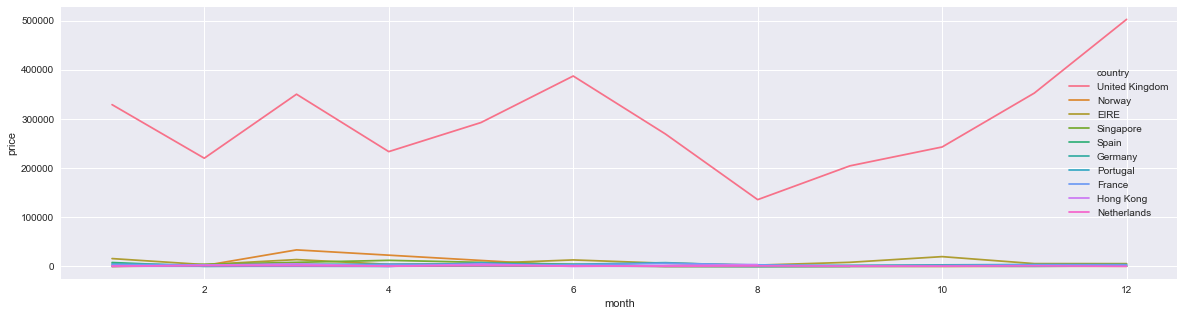

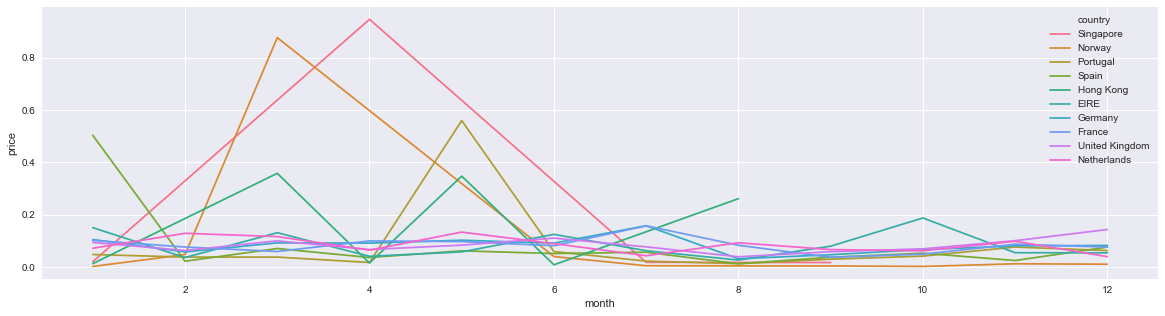

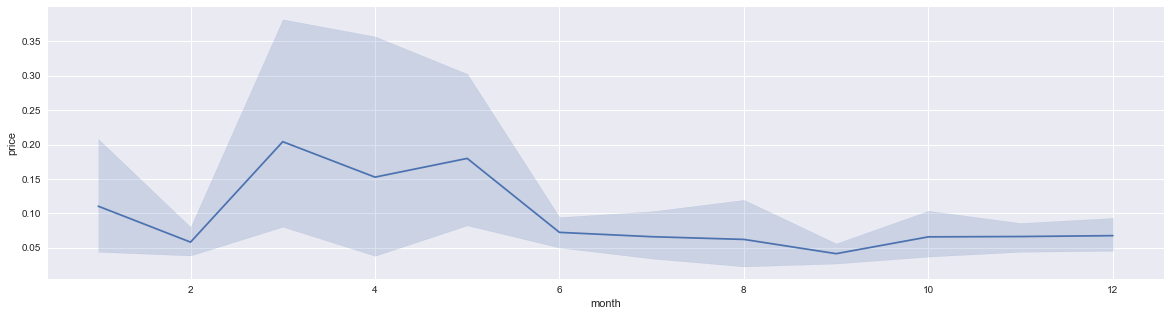

In [13]:
line_country_aggregation(df_scope, 'month', 'price', percentage=False, hue=True)
line_country_aggregation(df_scope, 'month', 'price', percentage=True, hue=True)
line_country_aggregation(df_scope, 'month', 'price', percentage=True, hue=False)


**There are most sales in the end of the year (November-December), because of UK entierly. If we would inspect the relative sales to each country, March-May is the period of most sales.**

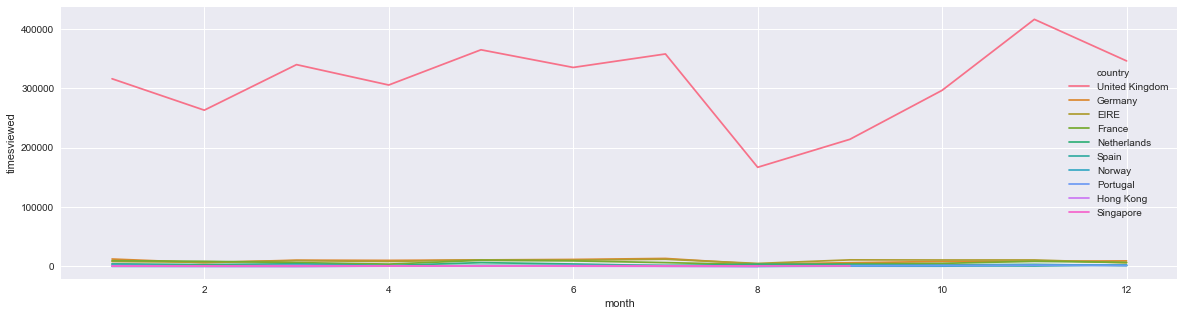

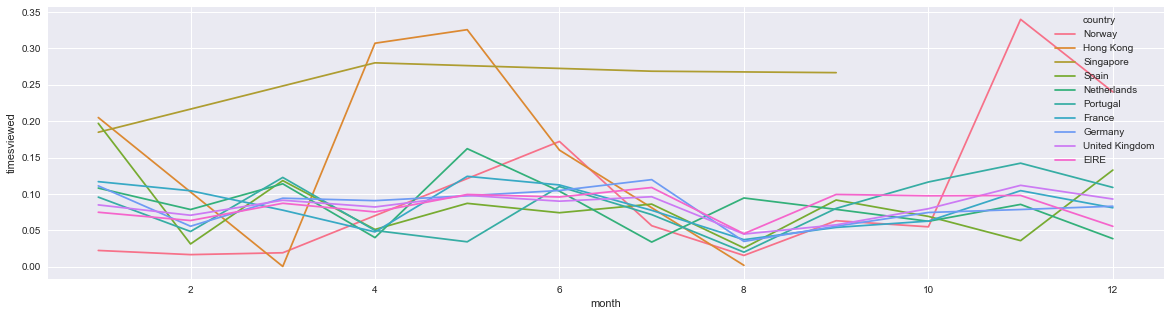

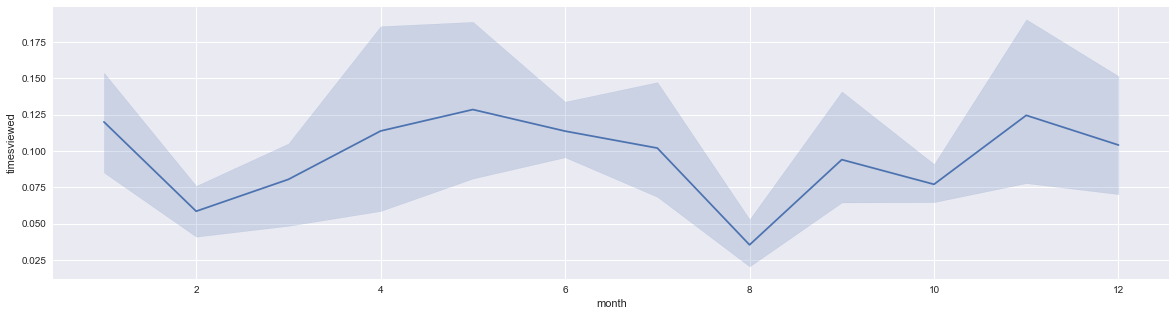

In [14]:
line_country_aggregation(df_scope, 'month', 'timesviewed', percentage=False, hue=True)
line_country_aggregation(df_scope, 'month', 'timesviewed', percentage=True, hue=True)
line_country_aggregation(df_scope, 'month', 'timesviewed', percentage=True, hue=False)

**This applies to timesview also.**

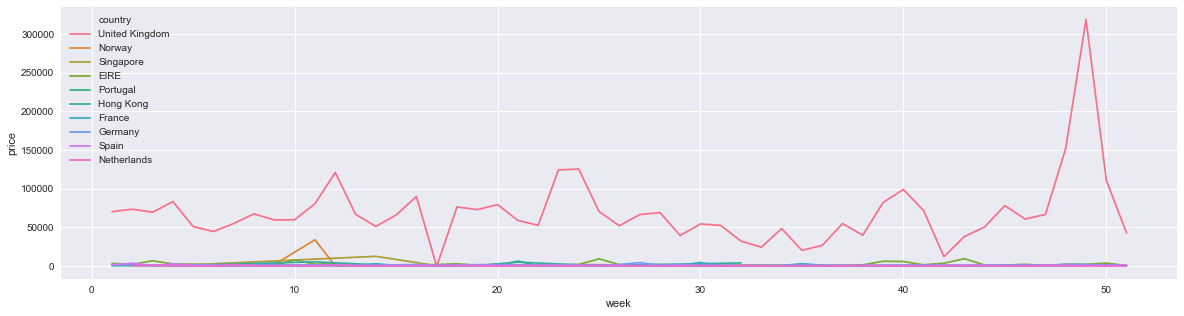

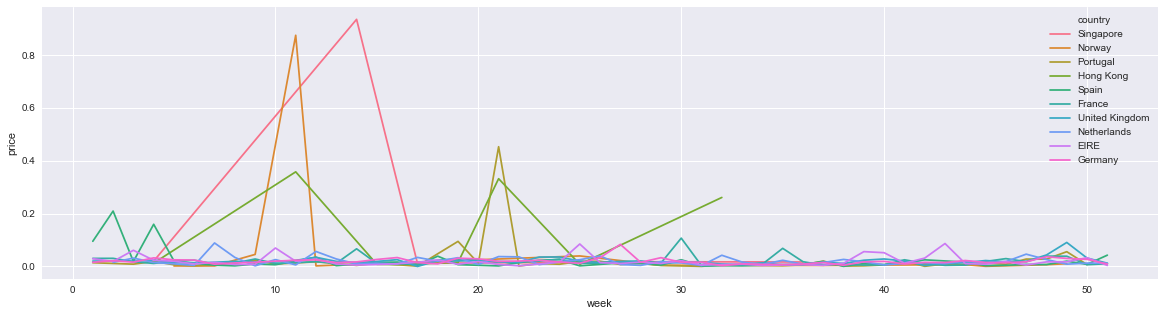

In [40]:
df_scope['week'] = df_scope['date'].dt.week
line_country_aggregation(df_scope, 'week', 'price', percentage=False, hue=True)
line_country_aggregation(df_scope, 'week', 'price', percentage=True, hue=True)

**However, the spike in UK seem to be very short lived.**

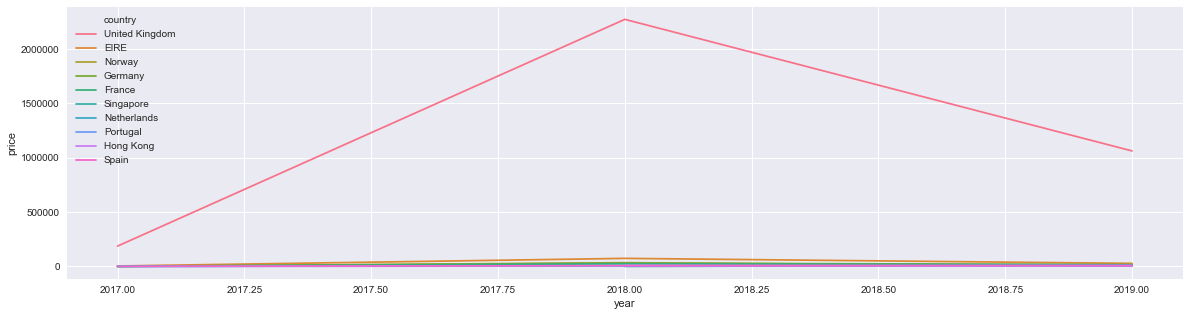

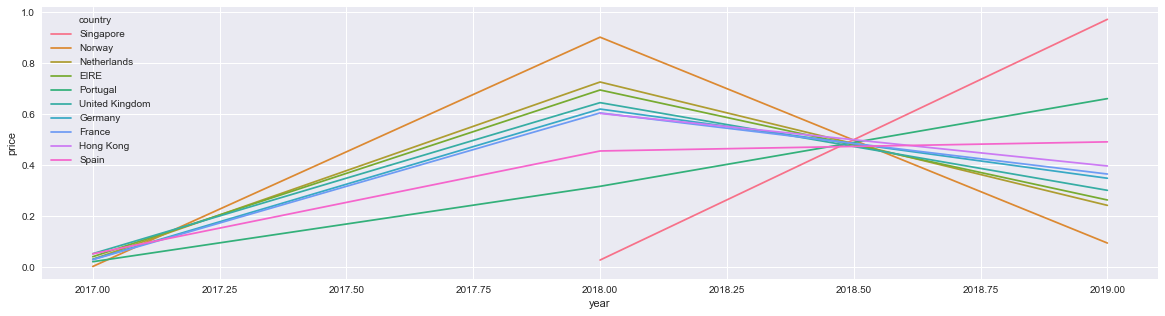

In [15]:
line_country_aggregation(df_scope, 'year', 'price', percentage=False, hue=True)
line_country_aggregation(df_scope, 'year', 'price', percentage=True, hue=True)

**The sales trend for UK went up from 2017 to 2018, then started to decline to 2019.**
**The sales trend most other countries did the same, except for Portugal which have had a constant growth, Spain having had less of a downtrend in the end, Singpore which started in 2018 and had just grown since then.**
**It is hard to say if Singapore will start going down, which most countries did after 1 year, or if it will define that and continue upward as it is already doing.**

In [59]:
df_m = df.groupby('country').resample('M', on='date').sum().reset_index()
print(df_m.shape)
df_m.head()

(635, 8)


,country,date,customerid,day,month,price,timesviewed,year
0,Australia,2017-11-30,293778.0,504,198,40.40,97,36306
1,Australia,2017-12-31,111806.0,93,108,19.25,49,18153
2,Australia,2018-01-31,0.0,0,0,0.00,0,0
3,Australia,2018-02-28,397240.0,477,64,60.23,350,64576
4,Australia,2018-03-31,243969.0,57,57,54.64,160,38342
